# Overview
In this notebook, I load in simulated household bills and then implement simple policies to investigate their effects on LMI houseohld bills.


## Load data and packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

df = pd.read_csv("household_df_NC_Duke.zip") # Duke in NC utility ID = 3046 or 5416


/tmp/ipykernel_181218/2798356324.py:9: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("household_df_NC_Duke.zip") # Duke in NC utility ID = 3046 or 5416


## Define parameters for policy savings

In [2]:
######## PARAMETERS #############

ECB_TARGET = 6
BILL_REDUCTION_PER_1000_2019 = 100
BILL_REDUCTION_PER_1000_2019_LOW = 70
BILL_REDUCTION_PER_1000_2019_HIGH = 130
INTEREST_RATE = 0.03
EFFICIENCY_MAX = 9996 #dollars 
EFFICIENCY_REDUCTION_MAX = 1010 #dollars 
PORTION_WEATHERIZATION_ASSISTANCE = 0.06 
INTEREST_RATE = 0.03
LOAN_TERM = 15 #years 
DISCOUNT_RATE = 0.05
YEARS_EFFICIENCY = 20 #years 
YEARS_PROGRAM = 15 #years 
SOLAR_DISCOUNT = 0.20
DEMAND_RESPONSE_RATE = 2000 #dollars per MWh
DEMAND_RESPONSE_ANNUAL = 0.10 #MWh/year
WORKING_HOURS_PER_YEAR = 2550 

## Calculating energy affordability metrics
ECB -> Energy Cost Burden
ECB -> Energy Affordability (Cost) Gap


In [3]:
df["ECB"] = df["ENERGY_COST"]/df["INCOME"]
df["ECG"] = (df["ECB"] - 0.06)*df["INCOME"]
df.loc[df["ECG"]<0,"ECG"] = 0

# Assign incomes to fractions of the federal poverty level based on household size 
poverty_dict = {1:12490,2:16910,3:21330,4:25750,5:30170,6:34590,7:39010}
poverty_fraction = np.NaN*np.zeros(len(df))
for household_size,poverty_limit in poverty_dict.items():
    idx = df["HOUSEHOLD_SIZE"]==household_size
    poverty_fraction[idx] = df.loc[idx,"INCOME"]/poverty_limit
df["POVERTY_FRACTION"] = poverty_fraction

## Calculating sequential effects on annual household energy bills based on policy

In [4]:
# Bill payment interest function
def PMT(rate,periods,amount):
    return amount*(rate*(1+rate)**periods/((1+rate)**periods-1))

# Add columns to dataframe about the impacts of sequetial application of policy measures
def calculate_policy_outcomes(df,
                              BILL_REDUCTION_PER_1000_2019 = BILL_REDUCTION_PER_1000_2019,
                              EFFICIENCY_MAX = EFFICIENCY_MAX,
                              PORTION_WEATHERIZATION_ASSISTANCE = PORTION_WEATHERIZATION_ASSISTANCE,
                              INTEREST_RATE = INTEREST_RATE,LOAN_TERM = LOAN_TERM,
                              SOLAR_DISCOUNT = SOLAR_DISCOUNT,
                              DEMAND_RESPONSE_RATE = DEMAND_RESPONSE_RATE,
                              DEMAND_RESPONSE_ANNUAL = DEMAND_RESPONSE_ANNUAL,
                             ):
    df["INVESTMENT_EFFICIENCY"] = df["ECG"]*1000/(BILL_REDUCTION_PER_1000_2019)
    df.loc[df["INVESTMENT_EFFICIENCY"]>EFFICIENCY_MAX,"INVESTMENT_EFFICIENCY"] = EFFICIENCY_MAX

    df["EXCESS_ECB"] = df["ECB"] - PORTION_WEATHERIZATION_ASSISTANCE
    df.loc[df["EXCESS_ECB"]<0,"EXCESS_ECB"] = 0

    df["WEATHERIZATION_ASSISTANCE"] = df["INVESTMENT_EFFICIENCY"]
    idx = df["EXCESS_ECB"]<0.1
    df.loc[idx,"WEATHERIZATION_ASSISTANCE"]=10*df.loc[idx,"EXCESS_ECB"]*df.loc[idx,"INVESTMENT_EFFICIENCY"]

    df["WEATHERIZATION_ONBILL"] = df["INVESTMENT_EFFICIENCY"] - df["WEATHERIZATION_ASSISTANCE"]
    df.loc[df["WEATHERIZATION_ONBILL"]<0,"WEATHERIZATION_ONBILL"] = 0

    df["EFFICIENCY_BILL_REDUCTION"] = df["INVESTMENT_EFFICIENCY"]*BILL_REDUCTION_PER_1000_2019/1000

    df["WEATHERIZATION_PAYMENT_ONBILL"] = df["WEATHERIZATION_ONBILL"].apply(lambda x: PMT(INTEREST_RATE,LOAN_TERM,x))

    # Bad labelling here. "NEW" refers to after just efficiency investment
    df["ENERGY_COST_NEW"] = df["ENERGY_COST"] - df["EFFICIENCY_BILL_REDUCTION"] + df["WEATHERIZATION_PAYMENT_ONBILL"]
        
    df["ECB_NEW"] = df["ENERGY_COST_NEW"]/df["INCOME"]

    df["ECB_REDUCTION"] = df["ECB"]-df["ECB_NEW"]

    df["ECG_NEW"] = df["ENERGY_COST_NEW"]-0.06*df["INCOME"]
    df.loc[df["ECG_NEW"]<0,"ECG_NEW"] = 0

    df["ENERGY_COST_NEW_SOLAR"] = (1-SOLAR_DISCOUNT)*df["ENERGY_COST_NEW"]

    df["ECB_NEW_SOLAR"] = df["ENERGY_COST_NEW_SOLAR"]/df["INCOME"]

    df["ENERGY_COST_NEW_SOLAR_DR"] = df["ENERGY_COST_NEW_SOLAR"]-DEMAND_RESPONSE_RATE*DEMAND_RESPONSE_ANNUAL

    df["ECB_NEW_SOLAR_DR"] = df["ENERGY_COST_NEW_SOLAR_DR"]/df["INCOME"]
    return df

df_expected = calculate_policy_outcomes(df.copy(),BILL_REDUCTION_PER_1000_2019 = BILL_REDUCTION_PER_1000_2019)
# df_low = calculate_policy_outcomes(df.copy(),BILL_REDUCTION_PER_1000_2019 = BILL_REDUCTION_PER_1000_2019_LOW)
# df_high = calculate_policy_outcomes(df.copy(),BILL_REDUCTION_PER_1000_2019 = BILL_REDUCTION_PER_1000_2019_HIGH)


In [5]:
np.sum(df["POVERTY_FRACTION"]<2) # Number of LMI households

1182471

## Stacked bar plot of the number of burdened households


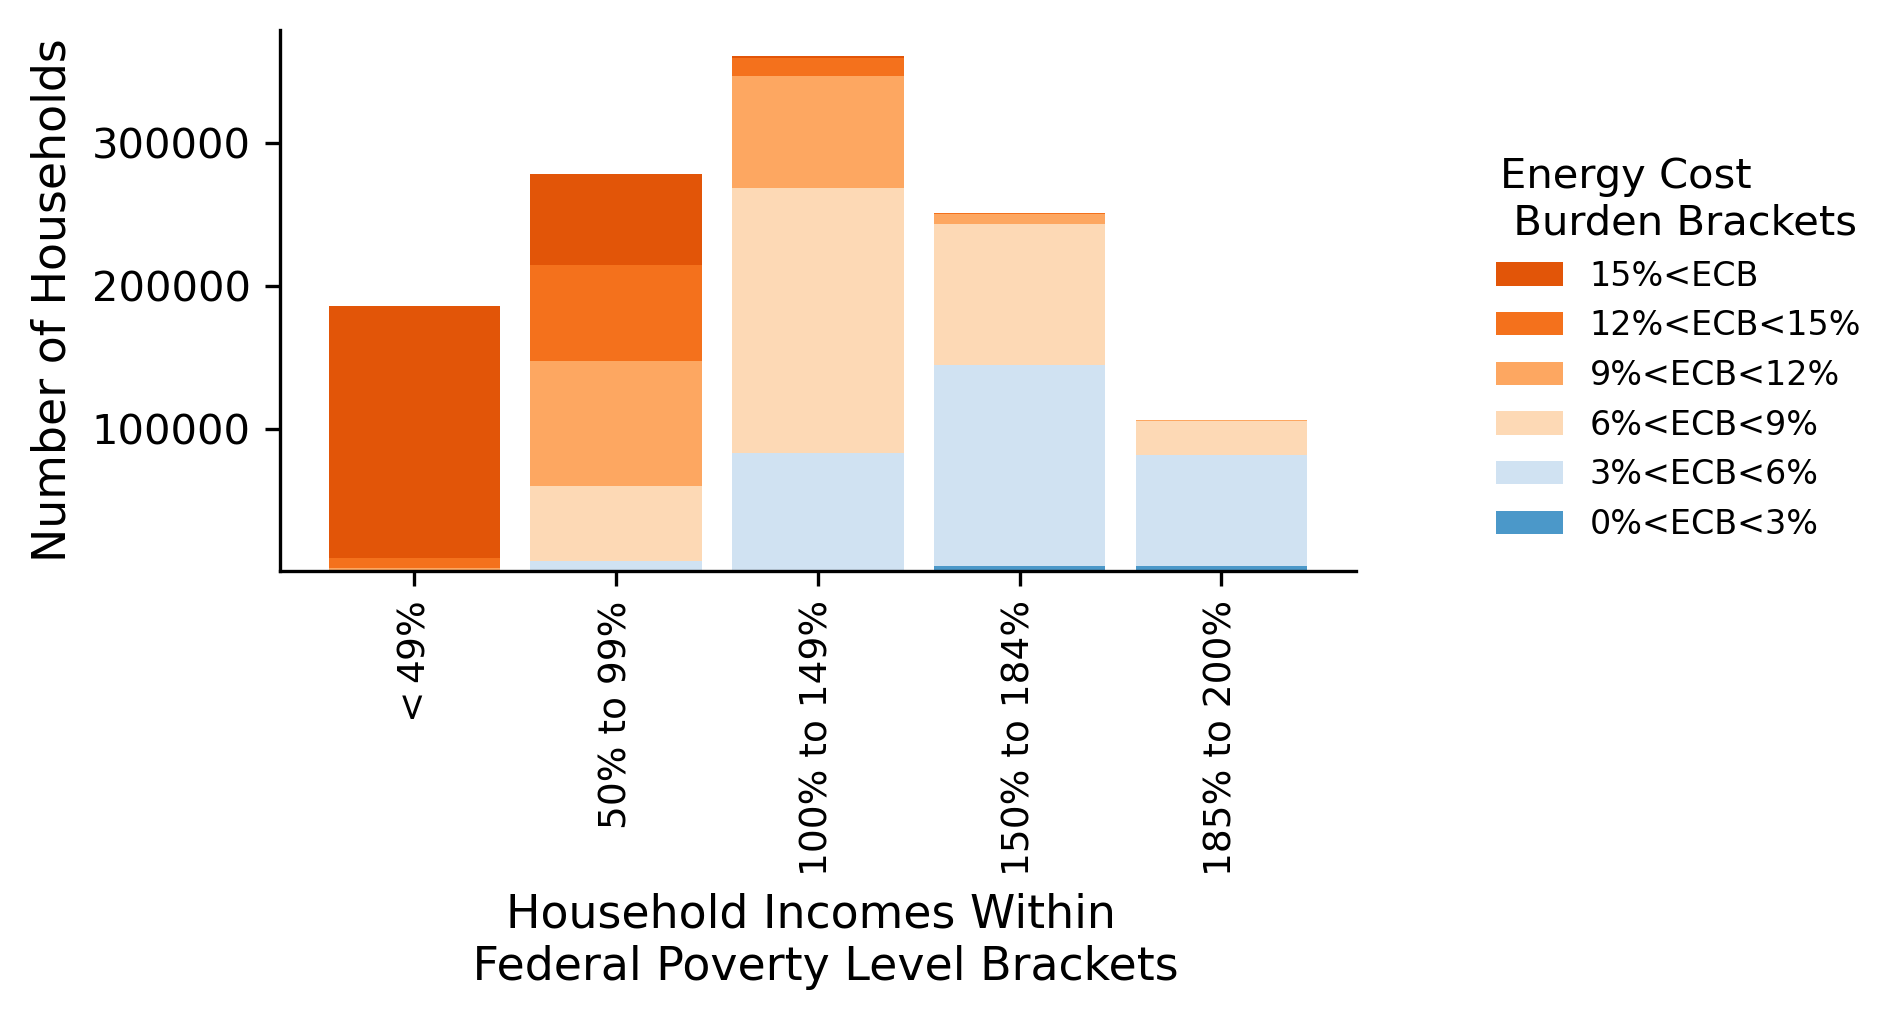

In [6]:
df = df_expected.copy()

ECB_brackets = [[-1, 0.03],[0.03,0.06],[0.06,0.09],[0.09,0.12],
               [0.12,0.15],[0.15,1000]]
ECB_strings = ["0%<ECB<3%","3%<ECB<6%","6%<ECB<9%","9%<ECB<12%",
               "12%<ECB<15%","15%<ECB"]


poverty_brackets = [[0,0.5],[0.5,1],[1,1.5],[1.5,1.85],[1.85,2]]
poverty_strings = ["$<$49%","50% to 99%","100% to 149%","150% to 184%","185% to 200%"]


fig, axs = plt.subplots(1,1,figsize=(7,3.5),dpi=300)
x=np.arange(len(poverty_strings))
width=0.85

top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='BlueOrange')
colors = [newcmp(c) for c in [0.2,0.4,0.6,0.7,0.8,0.85]]
number_dict = dict()
for ECB_string in ECB_strings:
    number_dict[ECB_string] = dict()
for pov_bracket,pov_string in zip(poverty_brackets,poverty_strings):
    for ECB_bracket,ECB_string in zip(ECB_brackets,ECB_strings):
        number_dict[ECB_string][pov_string] = np.sum((df["POVERTY_FRACTION"]>=pov_bracket[0]) & \
                                                     (df["POVERTY_FRACTION"]<=pov_bracket[1]) & \
                                                     (df["ECB"]>=ECB_bracket[0]) & \
                                                     (df["ECB"]<=ECB_bracket[1]))

bottoms = np.zeros(len(poverty_strings))
ax=axs
for ECB_bracket,ECB_string, color in zip(ECB_brackets,ECB_strings,colors):
    ax.bar(x, number_dict[ECB_string].values(), width, 
            label=ECB_string,
          bottom = bottoms,
          color = color)
    bottoms = bottoms + np.array([val for val in number_dict[ECB_string].values()])
ax.set_xticks(x)
ax.set_xlabel("Household Incomes Within \n Federal Poverty Level Brackets", 
              fontsize = 11)
ax.set_xticklabels(poverty_strings,rotation=90,fontsize = 9)
handles, labels = ax.get_legend_handles_labels()

ax.legend(reversed(handles),reversed(labels), 
           loc="lower center", 
           bbox_to_anchor=(1.3, 0),
           fontsize = 8,
           title="Energy Cost \n Burden Brackets",
         frameon=False)
ax.set_ylabel("Number of Households", fontsize = 11)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("households_burdened_fpl_brackets_Duke_1.png")


## Bar plot of energy affordability gaps within income brackets

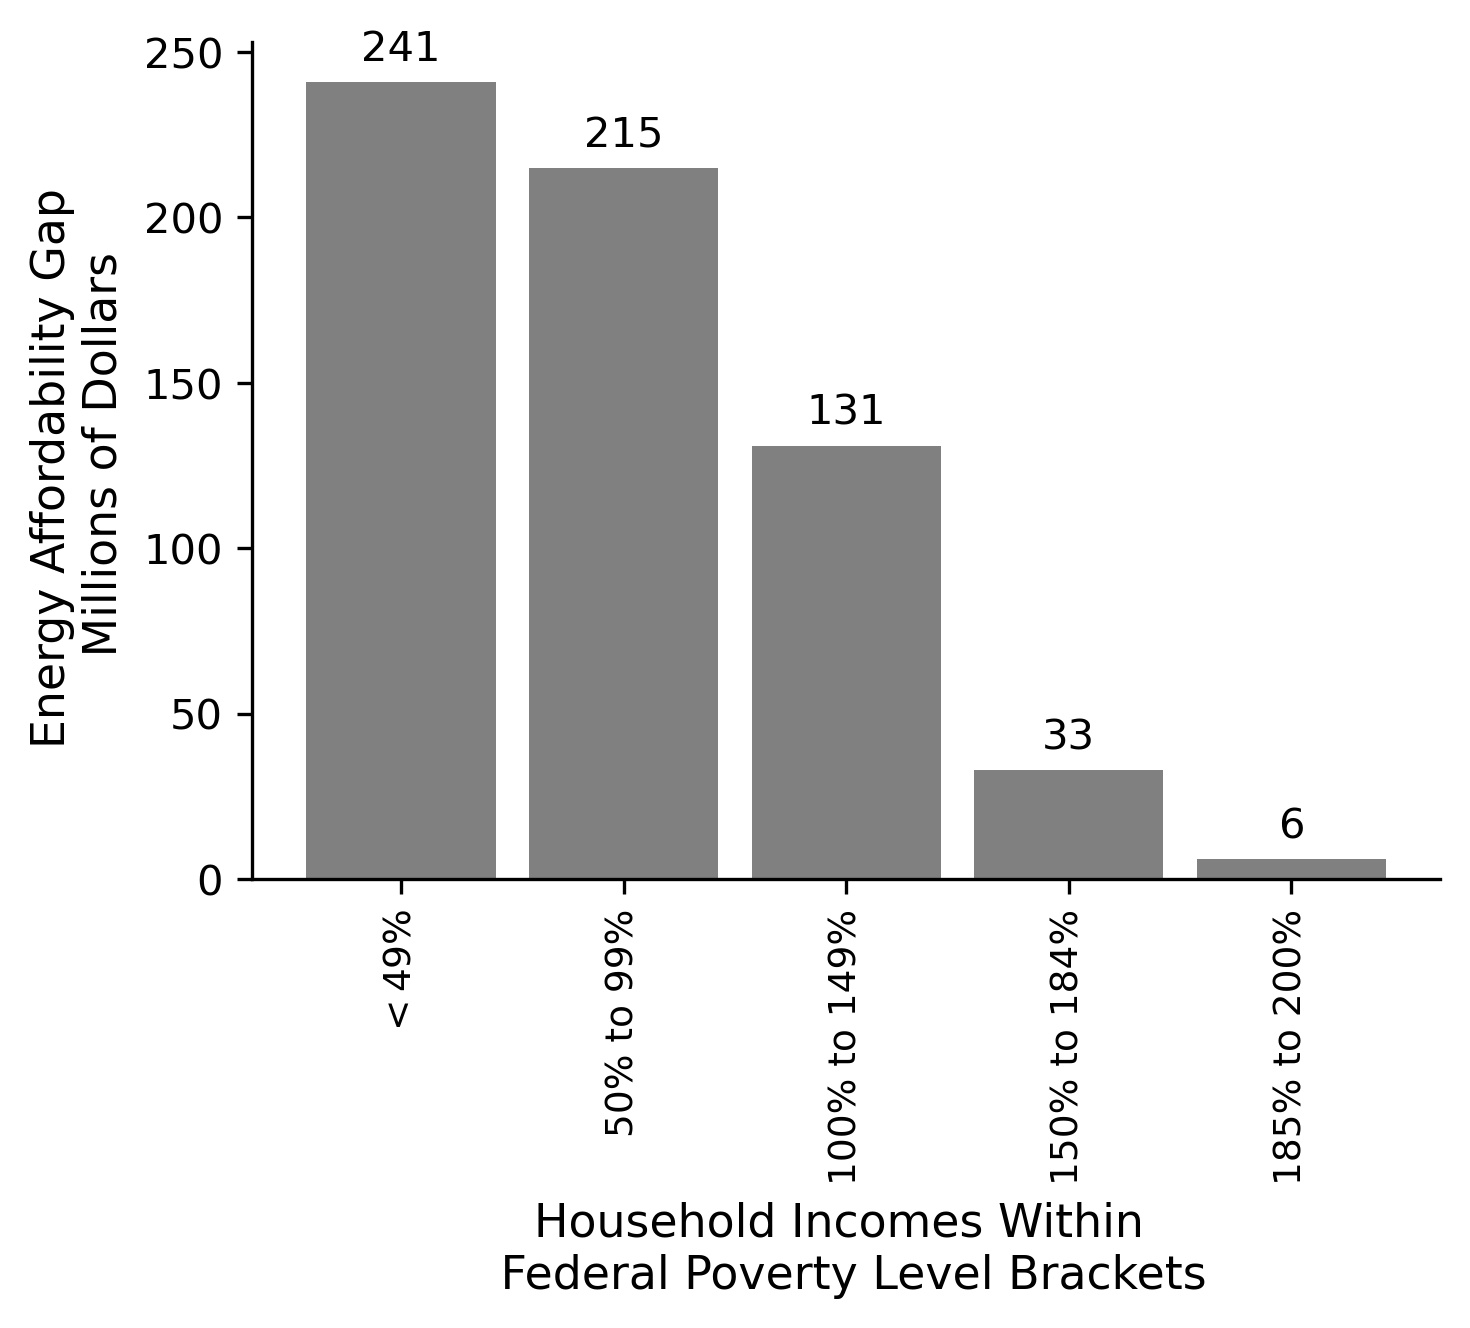

In [7]:
df = df_expected.copy()

poverty_brackets = [[0,0.5],[0.5,1],[1,1.5],[1.5,1.85],[1.85,2]]
poverty_strings = ["$<$49%","50% to 99%","100% to 149%","150% to 184%","185% to 200%"]


fig, axs = plt.subplots(1,1,figsize=(5,4.5),dpi=300)
x=np.arange(len(poverty_strings))
width=0.85

top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='BlueOrange')
colors = [newcmp(c) for c in [0.2,0.4,0.6,0.7,0.8,0.85]]

number_dict = dict()
for ECB_string in ECB_strings:
    number_dict[ECB_string] = dict()
for pov_bracket,pov_string in zip(poverty_brackets,poverty_strings):
    for ECB_bracket,ECB_string in zip(ECB_brackets,ECB_strings):
        number_dict[ECB_string][pov_string] = np.sum((df["POVERTY_FRACTION"]>=pov_bracket[0]) & \
                                                     (df["POVERTY_FRACTION"]<=pov_bracket[1]) & \
                                                     (df["ECB"]>=ECB_bracket[0]) & \
                                                     (df["ECB"]<=ECB_bracket[1]))

bottoms = np.zeros(len(poverty_strings))
ax = axs

WEATHERIZATION_ASSISTANCE_dict = dict()
ECG_dict = dict()
for bracket,string in zip(poverty_brackets,poverty_strings):
    WEATHERIZATION_ASSISTANCE_dict[string] = np.round(df.loc[(df["POVERTY_FRACTION"]>=bracket[0])&
                                           (df["POVERTY_FRACTION"]<=bracket[1]),"WEATHERIZATION_ASSISTANCE"].sum()/YEARS_EFFICIENCY/1000)
    ECG_dict[string] = np.round(df.loc[(df["POVERTY_FRACTION"]>=bracket[0])&
                                           (df["POVERTY_FRACTION"]<=bracket[1]),"ECG"].sum()/1000000)
x=np.arange(len(poverty_strings))
width=0.85
rects1 = ax.bar(x, ECG_dict.values(), 
                width, label='Initial assistance needed for all \n energy burdened households',color = "grey")

# WEATHERIZATION_ASSISTANCE_dict
ax.set_ylabel('Energy Affordability Gap \n Millions of Dollars', fontsize = 11)
ax.set_xticks(x)
ax.set_xticklabels(poverty_strings,rotation=90,fontsize = 9)

ax.bar_label(rects1, padding=3)
ax.set_xlabel("Household Incomes Within \n Federal Poverty Level Brackets",fontsize = 11)

ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig("households_energy_gap_Duke_2.png")


## Plot of the changes in cost burdens after policy implementation

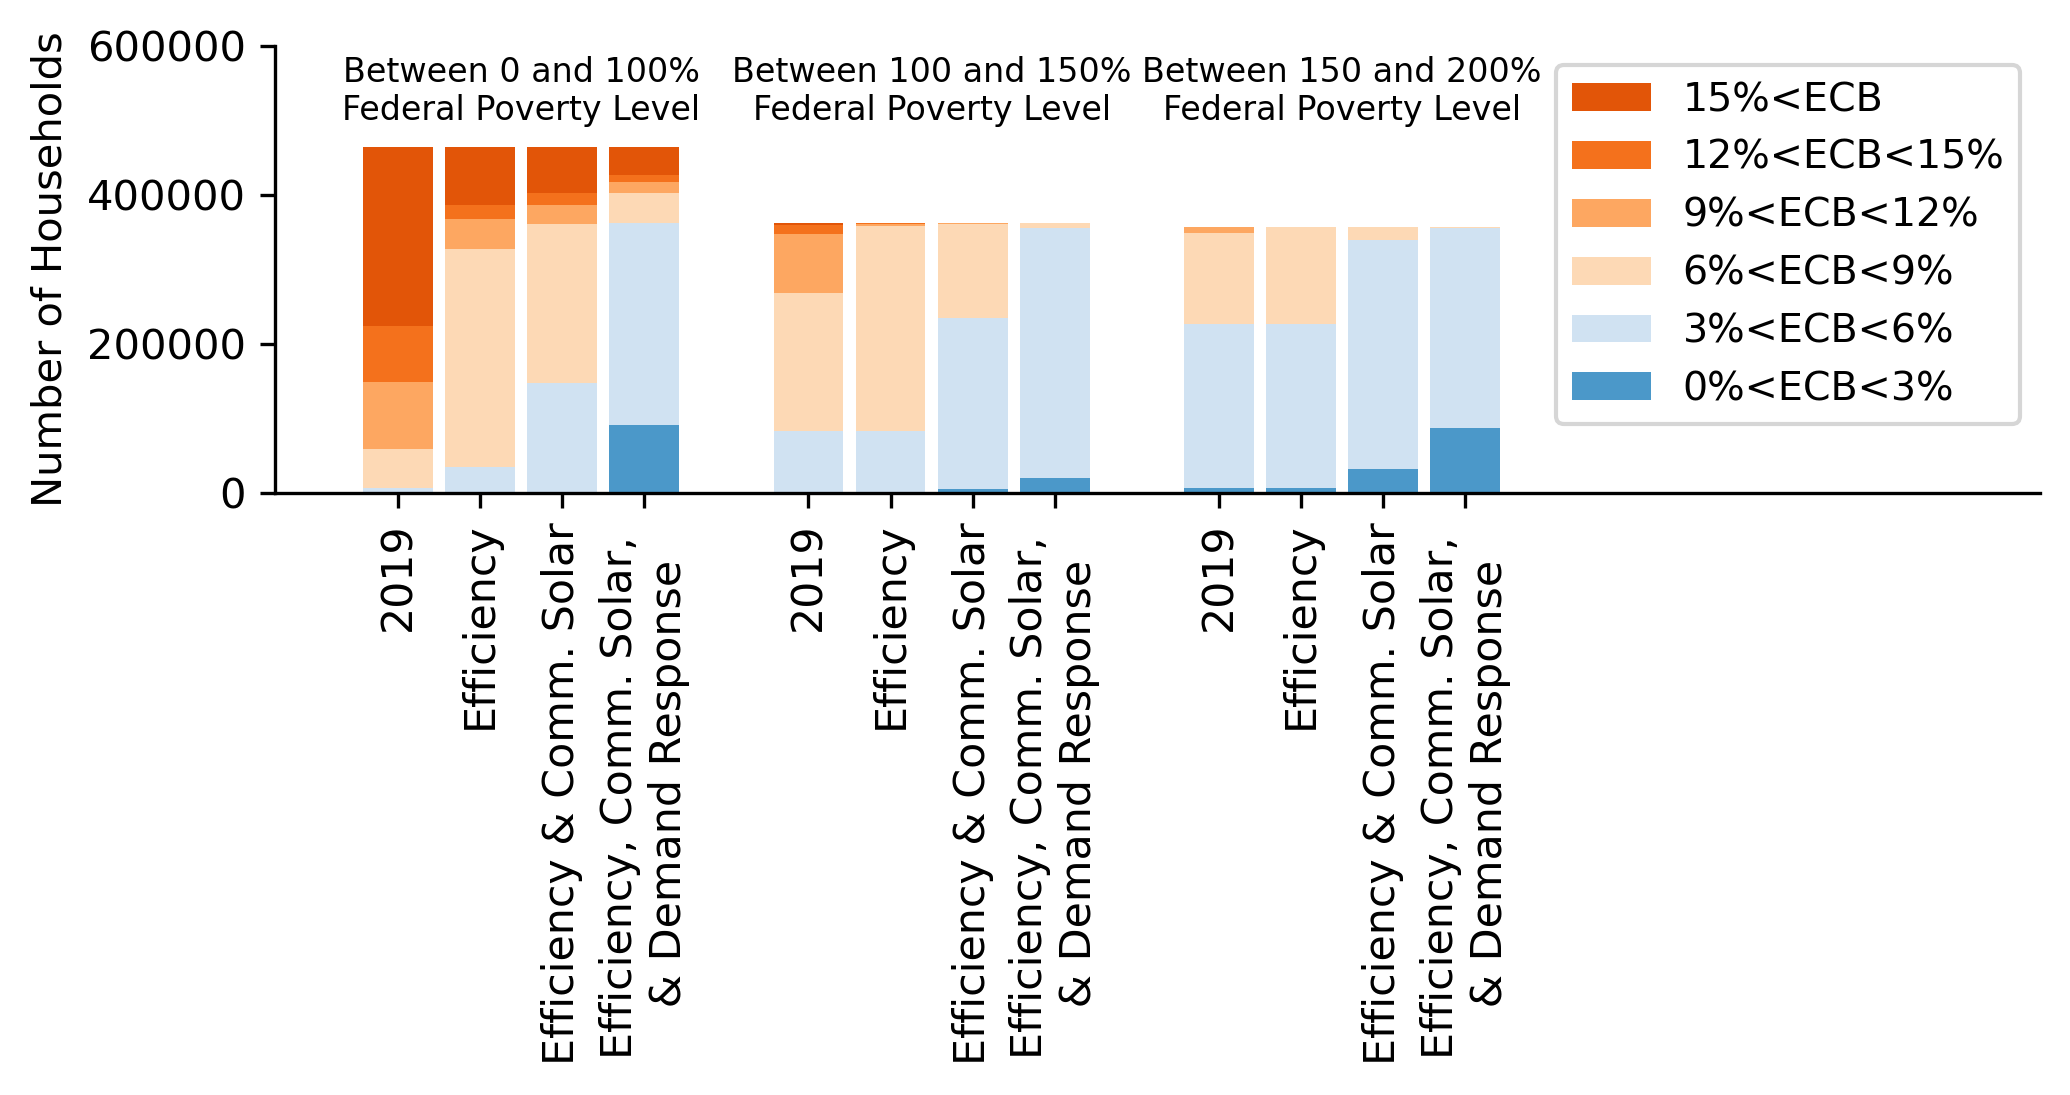

In [8]:
df = df_expected # CHANGE THIS FOR DIFFERENT EFFICIENCY SAVINGS SCENARIOS


ECB_brackets = [[-1, 0.03],[0.03,0.06],[0.06,0.09],[0.09,0.12],
               [0.12,0.15],[0.15,1000]]
ECB_strings = ["0%<ECB<3%","3%<ECB<6%","6%<ECB<9%","9%<ECB<12%",
               "12%<ECB<15%","15%<ECB"]

df_2 = df[(df["POVERTY_FRACTION"]>=1.5)&(df["POVERTY_FRACTION"]<=2)]
df_1 = df[(df["POVERTY_FRACTION"]>=1)&(df["POVERTY_FRACTION"]<=1.5)]
df_0 = df[(df["POVERTY_FRACTION"]>=0)&(df["POVERTY_FRACTION"]<=1)]

number_ECB_dict_0 = dict()
number_ECB_dict_1 = dict()
number_ECB_dict_2 = dict()
number_ECB_dict_0_new = dict()
number_ECB_dict_1_new = dict()
number_ECB_dict_2_new = dict()

number_ECB_dict_0_solar = dict()
number_ECB_dict_1_solar = dict()
number_ECB_dict_2_solar = dict()

number_ECB_dict_0_dr = dict()
number_ECB_dict_1_dr = dict()
number_ECB_dict_2_dr = dict()


for bracket,string in zip(ECB_brackets,ECB_strings):
    number_ECB_dict_0[string] = np.sum((df_0["ECB"]>bracket[0])&(df_0["ECB"]<=bracket[1]))
    number_ECB_dict_1[string] = np.sum((df_1["ECB"]>bracket[0])&(df_1["ECB"]<=bracket[1]))
    number_ECB_dict_2[string] = np.sum((df_2["ECB"]>bracket[0])&(df_2["ECB"]<=bracket[1]))
    
    number_ECB_dict_0_new[string] = np.sum((df_0["ECB_NEW"]>bracket[0])&(df_0["ECB_NEW"]<=bracket[1]))
    number_ECB_dict_1_new[string] = np.sum((df_1["ECB_NEW"]>bracket[0])&(df_1["ECB_NEW"]<=bracket[1]))
    number_ECB_dict_2_new[string] = np.sum((df_2["ECB_NEW"]>bracket[0])&(df_2["ECB_NEW"]<=bracket[1]))

    number_ECB_dict_0_solar[string] = np.sum((df_0["ECB_NEW_SOLAR"]>bracket[0])&(df_0["ECB_NEW_SOLAR"]<=bracket[1]))
    number_ECB_dict_1_solar[string] = np.sum((df_1["ECB_NEW_SOLAR"]>bracket[0])&(df_1["ECB_NEW_SOLAR"]<=bracket[1]))
    number_ECB_dict_2_solar[string] = np.sum((df_2["ECB_NEW_SOLAR"]>bracket[0])&(df_2["ECB_NEW_SOLAR"]<=bracket[1]))

    number_ECB_dict_0_dr[string] = np.sum((df_0["ECB_NEW_SOLAR_DR"]>bracket[0])&(df_0["ECB_NEW_SOLAR_DR"]<=bracket[1]))
    number_ECB_dict_1_dr[string] = np.sum((df_1["ECB_NEW_SOLAR_DR"]>bracket[0])&(df_1["ECB_NEW_SOLAR_DR"]<=bracket[1]))
    number_ECB_dict_2_dr[string] = np.sum((df_2["ECB_NEW_SOLAR_DR"]>bracket[0])&(df_2["ECB_NEW_SOLAR_DR"]<=bracket[1]))

number_0_dict = dict({0:number_ECB_dict_0,1:number_ECB_dict_0_new,2:number_ECB_dict_0_solar,3:number_ECB_dict_0_dr})
number_1_dict = dict({0:number_ECB_dict_1,1:number_ECB_dict_1_new,2:number_ECB_dict_1_solar,3:number_ECB_dict_1_dr})
number_2_dict = dict({0:number_ECB_dict_2,1:number_ECB_dict_2_new,2:number_ECB_dict_2_solar,3:number_ECB_dict_2_dr})

fig,ax = plt.subplots(1,1,figsize=(7,3.75),dpi=300)
x_s = [0,1,2,3,5,6,7,8,10,11,12,13]
x=x_s[0:4]
width=0.85

cmap = matplotlib.cm.get_cmap('seismic')
color_high_ECB = 247, 145, 30
color_low_ECB = 3,78,123
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='BlueOrange')

colors = [newcmp(c) for c in [0.2,0.4,0.6,0.7,0.8,0.85]]
lower_vals = [0,0,0,0]
for bracket,string,c in zip(ECB_brackets,ECB_strings,colors):
    ax.bar(x, [item[string] for item in number_0_dict.values()], 
               width,  
               bottom=lower_vals,
               label=string,
              color=c)
    for idx in range(len(lower_vals)):
        lower_vals[idx] = lower_vals[idx] + number_0_dict[idx][string]

x=x_s[4:8]
# x=np.arange(4)+5

lower_vals = [0,0,0,0]
for bracket,string,c in zip(ECB_brackets,ECB_strings,colors):
    ax.bar(x, [item[string] for item in number_1_dict.values()], 
               width,  
               bottom=lower_vals,
               label="",
              color=c)
    for idx in range(len(lower_vals)):
        lower_vals[idx] = lower_vals[idx] + number_1_dict[idx][string]

        
x=x_s[8:12]
# x=np.arange(4)+5
lower_vals = [0,0,0,0]
for bracket,string,c in zip(ECB_brackets,ECB_strings,colors):
    ax.bar(x, [item[string] for item in number_2_dict.values()], 
               width,  
               bottom=lower_vals,
               label="",
              color=c)
    for idx in range(len(lower_vals)):
        lower_vals[idx] = lower_vals[idx] + number_2_dict[idx][string]

ax.set_xticks(x_s)
ax.set_xticklabels(["2019","Efficiency","Efficiency & Comm. Solar","Efficiency, Comm. Solar, \n & Demand Response",
               "2019","Efficiency","Efficiency & Comm. Solar","Efficiency, Comm. Solar, \n & Demand Response",
               "2019","Efficiency","Efficiency & Comm. Solar","Efficiency, Comm. Solar, \n & Demand Response"],
               rotation=90,fontsize=10.25)


ax.set_xlim(-1.5,20)
ax.set_ylim(0,600000)

y_text = 500000

ax.text(1.5,y_text,"Between 0 and 100%\nFederal Poverty Level",
        fontsize=8,horizontalalignment='center',)

ax.text(6.5,y_text,"Between 100 and 150%\nFederal Poverty Level",
        fontsize=8,horizontalalignment='center',)

ax.text(11.5,y_text,"Between 150 and 200%\nFederal Poverty Level",
        fontsize=8,horizontalalignment='center',)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels),fontsize = 9.5)
# ax.legend()
ax.set_ylabel("Number of Households")
# ax.set_yticks([0,50000,100000,150000,200000,250000])
# ax.set_yticklabels([0,50,100,150,200,250])
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig("Policy_results_Duke.png")

## Cost of policies over timespan

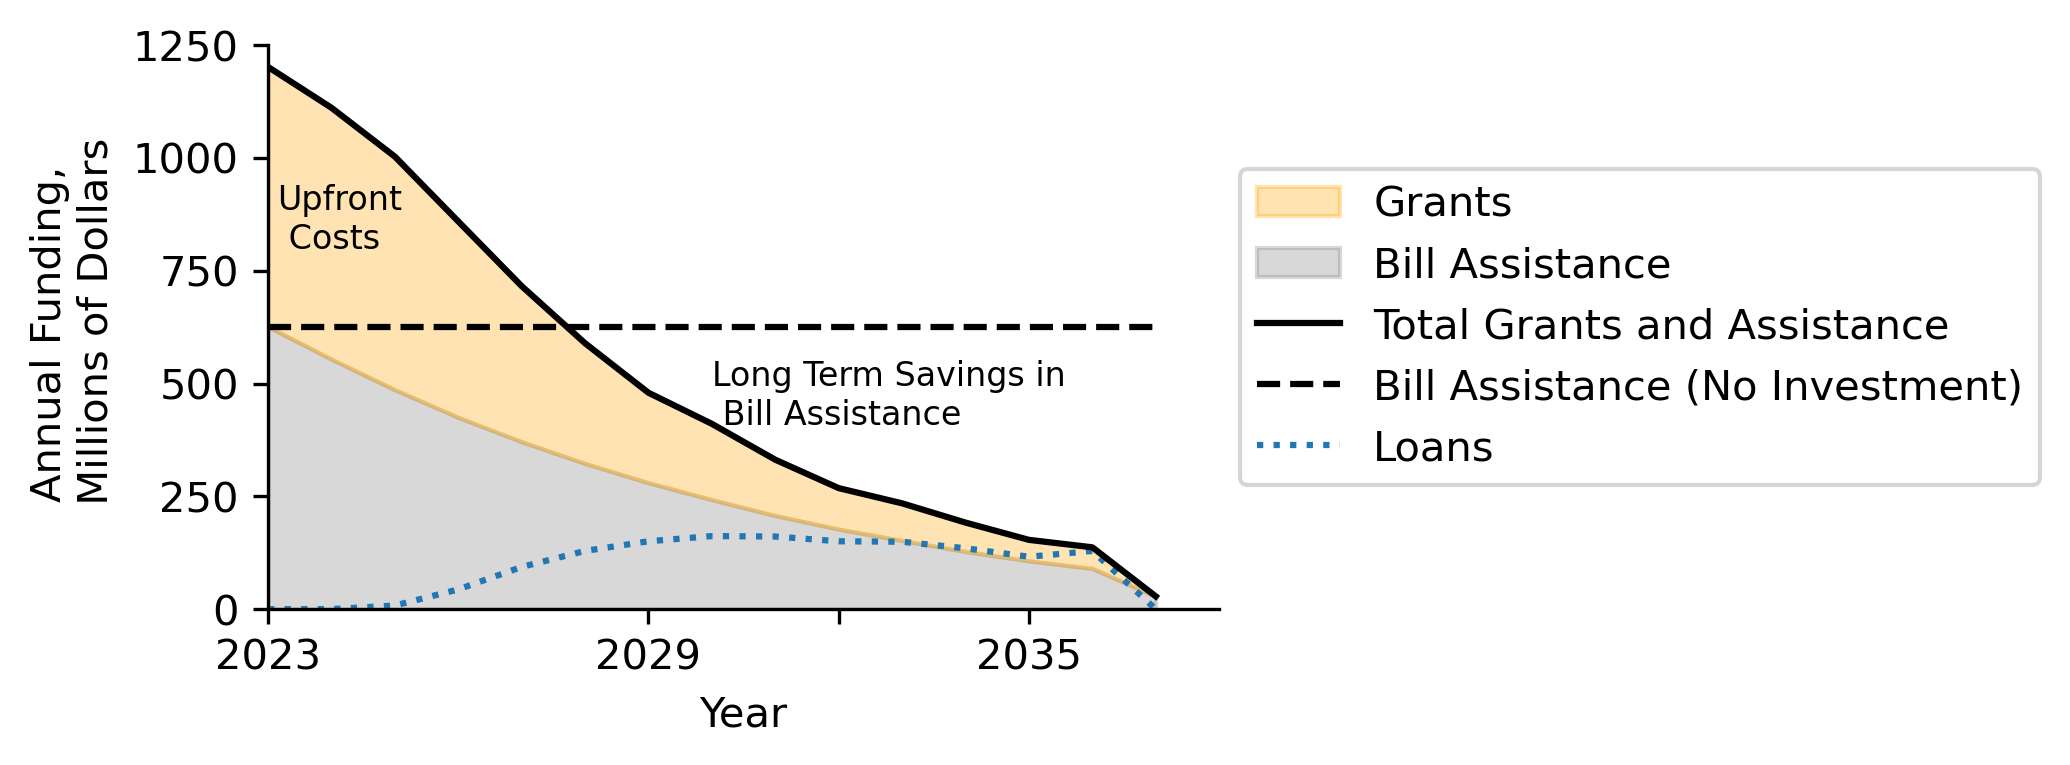

In [9]:
df = df_expected.copy()

df["ECG_NEW_SOLAR_DR"] = df["ENERGY_COST_NEW_SOLAR_DR"]-0.06*df["INCOME"]
df.loc[df["ECG_NEW_SOLAR_DR"]<0,"ECG_NEW_SOLAR_DR"] = 0

df["ECG_NEW_SOLAR"] = df["ENERGY_COST_NEW_SOLAR"]-0.06*df["INCOME"]
df.loc[df["ECG_NEW_SOLAR"]<0,"ECG_NEW_SOLAR"] = 0

df_LMI = df[df["POVERTY_FRACTION"]<2]
idx_post = np.zeros(len(df_LMI))==1
idx_pre = np.ones(len(df_LMI))==1
idx_sorted = np.argsort(df_LMI["INCOME"]).to_numpy()
years = np.arange(2023,2038)

grants_ECG = np.zeros(len(years))
grants_weatherization = np.zeros(len(years))
loans = np.zeros(len(years))
delta_household = np.round(len(df_LMI)/20)

total_energy_after_efficiency = dict()

for y in range(len(years)):
    if years[y]<2037:
        idx_new = idx_sorted[int(delta_household*y):int(delta_household*(y+1))]
        grants_ECG[y] = np.sum(df_LMI.loc[idx_pre,"ECG"])
        grants_ECG[y] += np.sum(df_LMI.loc[idx_post,"ECG_NEW_SOLAR_DR"])
        grants_weatherization[y] += np.sum(df_LMI.iloc[idx_new]["WEATHERIZATION_ASSISTANCE"])
        loans[y] = np.sum(df_LMI.iloc[idx_new]["WEATHERIZATION_ONBILL"])
        total_energy_after_efficiency[years[y]] = df_LMI["BTU_EL"].sum()*2.93071e-7*(df_LMI.loc[idx_pre,"ENERGY_COST"].sum() + df_LMI.loc[idx_post,"ENERGY_COST_NEW"].sum())/df_LMI.loc[:,"ENERGY_COST"].sum()
        if y<len(years)-1:
            idx_post[idx_new] = True
            idx_pre[idx_new] = False
    else:
        grants_ECG[y] += np.sum(df_LMI.loc[:,"ECG_NEW_SOLAR_DR"])
        grants_weatherization[y] = 0
        loans[y]=0
        total_energy_after_efficiency[years[y]] = df_LMI["BTU_EL"].sum()*2.93071e-7*(df_LMI.loc[idx_pre,"ENERGY_COST"].sum() + df_LMI.loc[idx_post,"ENERGY_COST_NEW"].sum())/df_LMI.loc[:,"ENERGY_COST"].sum()
    if y<len(years)-1:
        idx_post[idx_new] = True
        idx_pre[idx_new] = False

fig,ax = plt.subplots(1,1,figsize=(7,2.6),dpi=300)

ax.plot(years,loans/1000000,
        label="Loans",
       linestyle = "dotted",
       )

ax.plot(years,grants_ECG*0+grants_ECG[0]/1000000,label = "Bill Assistance (No Investment)",
       color = 'black',linestyle = "dashed")

ax.plot(years,(grants_ECG+grants_weatherization)/1000000,
        label = "Total Grants and Assistance",
        color='black')

ax.fill_between(years, (grants_ECG)/1000000, y2=0*grants_weatherization/1000000,
                label = "Bill Assistance",
               color = "grey",
               alpha = 0.3)

ax.fill_between(years, (grants_ECG+grants_weatherization)/1000000, y2=grants_ECG/1000000,
                label = "Grants",
               color = "orange",
               alpha = 0.3)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1],loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(years[0:len(years)+2:2])
ax.set_xticklabels([str(year) for year in years[0:len(years)+2:2]])
ax.set_xlabel("Year")
ax.set_ylabel("Annual Funding, \n Millions of Dollars")

ax.set_xlim(2023,2038)
ax.set_xticks((2023,2029,2032,2035))

ax.set_ylim(0,1250)
ax.grid(False)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.annotate("Upfront\n Costs",xy = (2023.15,800),fontsize = 8)
ax.annotate("Long Term Savings in \n Bill Assistance",xy = (2030,410),fontsize = 8)

plt.tight_layout()
plt.savefig("Policy_savings_duke.png")